# Bone age prediction of hand radiographs using Neural Networks

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers, Input
from keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from sklearn.metrics import r2_score
import time
import zipfile
import pathlib

In [ ]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/scripts/utils.py" utils.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/scripts/models.py" models.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/scripts/inc_v4.py" inc_v4.py
from models import *
from utils import *

In [ ]:
import matplotlib as mpl
# setting some matplotlib parameters for plots
mpl.rcParams['axes.grid'] = False
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams.update({'font.size': 22})

%matplotlib inline
np.random.seed(1)

cmap = mpl.cm.get_cmap('viridis')
COLORS = [cmap(0.0), cmap(0.14), cmap(0.28), cmap(0.42), cmap(0.56), cmap(0.7), cmap(0.84)]

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
TRAIN_PATH = PATH + 'data/Bone Age Training Set/'
VAL_PATH = PATH + 'data/Bone Age Validation Set/'
TEST_PATH = PATH + 'data/Bone Age Test Set/'
TRAIN_PATH_MASKS = TRAIN_PATH + 'train_masks/'
VAL_PATH_MASKS = VAL_PATH + 'val_masks/'
TEST_PATH_MASKS = TEST_PATH + 'test_masks/'

In [ ]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)
BATCH_SIZE = 32
EPOCHS = 50
CONTRAST_FACTOR = 3.5

## Retrieve datasets

In [ ]:
with zipfile.ZipFile(TRAIN_PATH + 'boneage-training-dataset-masked2.zip', 'r') as f:
  f.extractall('.')
!mv boneage-training-dataset-masked2/ boneage-training-dataset-masked/

In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Validation Set/boneage-validation-dataset-masked2' 'boneage-validation-dataset-masked'

In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Test Set/boneage-test-dataset-masked2' 'boneage-test-dataset-masked'

## Creating dataframes

In [ ]:
train_df = load_filenames(TRAIN_PATH + 'train.csv', TRAIN_PATH + 'boneage-training-dataset')
validation_df = load_filenames(VAL_PATH + 'Validation Dataset.csv', VAL_PATH + 'boneage-validation-dataset-1', 
                               VAL_PATH + 'boneage-validation-dataset-2')
test_df = load_filenames(TEST_PATH + 'Bone age ground truth.xlsx', TEST_PATH + 'Bone Age Test Set/Test Set Images')

# normalize boneage value to accelerate training
MEAN_BONE_AGE = train_df['boneage'].mean()
STD_BONE_AGE = train_df['boneage'].std()
train_df['boneage_n'] = (train_df['boneage'] - MEAN_BONE_AGE) / STD_BONE_AGE
validation_df['boneage_n'] = (validation_df['boneage'] - MEAN_BONE_AGE) / STD_BONE_AGE
test_df['boneage_n'] = (test_df['boneage'] - MEAN_BONE_AGE) / STD_BONE_AGE

# steps between epochs
train_steps = int(np.ceil(train_df.shape[0] / BATCH_SIZE))
val_steps = int(np.ceil(validation_df.shape[0] / BATCH_SIZE))

display(train_df.head(3))
display(validation_df.head(3))
display(test_df.head(3))

,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,0,180,1.279181
1,/content/drive/My Drive/Colab Notebooks/Human ...,0,12,-2.800269
2,/content/drive/My Drive/Colab Notebooks/Human ...,0,94,-0.809109


,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,0,30,-2.363185
1,/content/drive/My Drive/Colab Notebooks/Human ...,1,162,0.842097
2,/content/drive/My Drive/Colab Notebooks/Human ...,0,18,-2.654575


,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,1,168.934249,1.010477
1,/content/drive/My Drive/Colab Notebooks/Human ...,1,169.652678,1.027922
2,/content/drive/My Drive/Colab Notebooks/Human ...,1,73.256112,-1.312821


## Preprocessing

### Contrast enhancement



In [ ]:
!mkdir train_contrast
!mkdir val_contrast
!mkdir test_contrast
clahe = cv2.createCLAHE(clipLimit=1.5)
train_df['image'].apply(lambda im: cv2.imwrite('train_contrast/' + im.split('/')[-1], clahe.apply(cv2.imread(im, 0))))
validation_df['image'].apply(lambda im: cv2.imwrite('val_contrast/' + im.split('/')[-1], clahe.apply(cv2.imread(im, 0))))
test_clahe = cv2.createCLAHE(clipLimit=2)
test_df['image'].apply(lambda im: cv2.imwrite('test_contrast/' + im.split('/')[-1], test_clahe.apply(cv2.imread(im, 0))))

### Image segmentation

Load mask images

In [ ]:
# Build lists with corresponding masked/original images
original_imgs = []
mask_imgs = []

p = pathlib.Path(PATH+'boneage-training-dataset-masks/')   
mask_img_names = [x.stem for x in p.glob('*.png')]
for number in mask_img_names:
  original_imgs.append(load_hand_image(TRAIN_PATH + "boneage-training-dataset/" + number + ".png", IMG_SIZE, grayscale=False))
  mask_imgs.append(load_hand_image(PATH + 'boneage-training-dataset-masks/' + number + ".png", IMG_SIZE, grayscale=False))

test_imgs=[]
for number in range(3000,3050):
  try:
    test_imgs.append(load_hand_image(TRAIN_PATH + "boneage-training-dataset/" + str(number) + ".png", IMG_SIZE, grayscale=False))
  except Exception:
    pass


Build Tensorflow datasets

In [ ]:
# Normalize RGB values to be in the 0-1 range
original_normalized = normalize_values(original_imgs)
masked_normalized = normalize_values(mask_imgs)
test_imgs = normalize_values(test_imgs)

In [ ]:
datasets_path = ''

# Build the datasets
from sklearn.model_selection import train_test_split
datasets_names = ['train_dataset', 'validation_dataset','test_dataset']
X_train, X_test, Y_train, Y_test = train_test_split(np.asarray(original_normalized), masked_normalized, test_size=0.08, random_state=42)
print("Training masks: ", len(X_train),"  Validation masks: ", len(X_test))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = tf.data.Dataset.from_tensor_slices(test_imgs)

# Save datasets
datasets = [train_dataset, validation_dataset,test_dataset]
for i in range(len(datasets)):
  tf.data.experimental.save(datasets[i], datasets_path + datasets_names[i])

Training masks:  185   Validation masks:  17


In [ ]:
datasets_path=PATH + 'tf_datasets/mask_datasets/'

# Build the datasets
from sklearn.model_selection import train_test_split
datasets_names = ['train_dataset', 'validation_dataset','test_dataset']
X_train, X_test, Y_train, Y_test = train_test_split(np.asarray(original_normalized), masked_normalized, test_size=0.08, random_state=42)
print("Training masks: ", len(X_train),"  Validation masks: ", len(X_test))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = tf.data.Dataset.from_tensor_slices(test_imgs)

# Save datasets
datasets = [train_dataset, validation_dataset,test_dataset]
for i in range(len(datasets)):
  tf.data.experimental.save(datasets[i], datasets_path + datasets_names[i])

Training masks:  185   Validation masks:  17


Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


#### Load pre-saved datasets

In [ ]:
train_dataset = tf.data.experimental.load(datasets_path + 'train_dataset')
test_dataset = tf.data.experimental.load(datasets_path + 'test_dataset')
validation_dataset = tf.data.experimental.load(datasets_path + 'validation_dataset')

#### Contrast enhancement and data augmentation

This step is performed here in an offline manner. It is then repeated for the CNNs predictors, but this time online during training.

In [ ]:
# Custom augmention layer
class Augment(tf.keras.layers.Layer):
   def __init__(self, seed=42):
     super(Augment, self).__init__()
     self.seed = seed
     self.augment_inputs = tf.keras.layers.RandomZoom(0.1, 0.1, seed=seed, fill_mode='constant')
     self.augment_inputs2 = tf.keras.layers.RandomRotation(0.1, seed=seed, fill_mode='constant')
     self.augment_labels = tf.keras.layers.RandomZoom(0.1, 0.1, seed=seed, fill_mode='constant')
     self.augment_labels2 = tf.keras.layers.RandomRotation(0.1, seed=seed, fill_mode='constant')

   def call(self, inputs, labels):
      x = self.augment_inputs(inputs)
      x = self.augment_inputs2(x)
      y = self.augment_labels(labels)
      y =  self.augment_labels2(y)
      return x, y

Preprocessing function:

*   contrast = apply contrast augmentation to all the datasets
*   augment = apply augmentation to the train dataset if True
*   count = number of augmented copies of the train dataset


In [ ]:
def preprocess(train_dataset, validation_dataset, test_dataset, contrast=True, augment=True, count=6):
  if contrast:
    # Apply contrast enhancement with default value
    train_dataset = train_dataset.map(lambda x,y: contrast_enhancement(x, y, CONTRAST_FACTOR))
    validation_dataset = validation_dataset.map(lambda x,y: contrast_enhancement(x, y, CONTRAST_FACTOR))
    test_dataset = test_dataset.map(lambda x: image_contrast_enhancement(x, CONTRAST_FACTOR))
    print("Images contrast is improved by a factor of {} .".format(CONTRAST_FACTOR))
  # Batching
  train_dataset = train_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  test_dataset = test_dataset.batch(BATCH_SIZE)

  if augment:
    # Train dataset augmentation: count defines how many times we apply the process.
    augmented_train_ds = train_dataset
    for i in range(1,count):
      augmented_train_ds = augmented_train_ds.concatenate(train_dataset.map(Augment(i)))
    print("Train dataset was augmented by {} times.".format(count))
    train_dataset = augmented_train_ds
  return (train_dataset, validation_dataset, test_dataset)

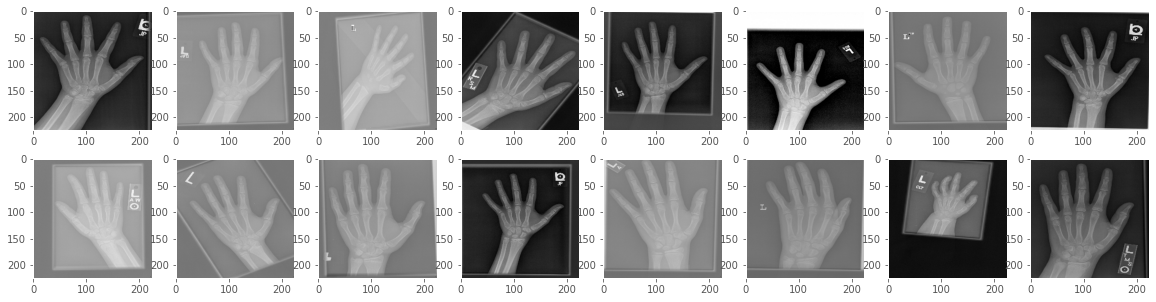

In [ ]:
# Example of train datset before preprocessing
batch = list(train_dataset.batch(BATCH_SIZE).take(1).as_numpy_iterator())

fig, ax = plt.subplots(2,8, figsize=(20, 5))
for i,img in enumerate(batch[0][0][:16]):
  if i>7:
    ax[1,i-8].imshow(img)
  else:
    ax[0,i].imshow(img)

In [ ]:
# Apply preprocessing function
train_dataset, validation_dataset, test_dataset = preprocess(train_dataset, validation_dataset, test_dataset, count=40)

Images contrast is improved by a factor of 3.5 .
Train dataset was augmented by 40 times.


In [ ]:
# Apply preprocessing function
train_dataset, validation_dataset, test_dataset = preprocess(train_dataset, validation_dataset, test_dataset, count=40)

<ipython-input-13-d4e884b8437c>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  b=np.array(a)


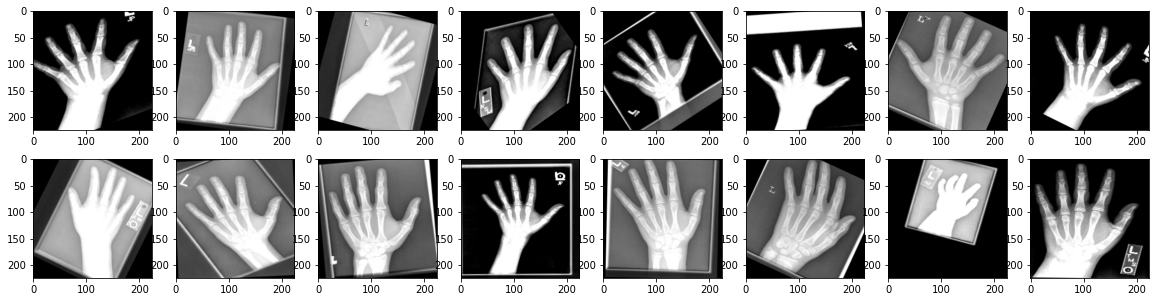

In [ ]:
# Example of train datset after preprocessing

a = list(train_dataset.take(13).as_numpy_iterator())
b = np.array(a)
fig, ax = plt.subplots(2,8, figsize=(20, 5))
for i,img in enumerate(b[12][0][:16]):
  if i>7:
    ax[1,i-8].imshow(img)
  else:
    ax[0,i].imshow(img)


####Define U-Net

We define encoder and decoder indipendently, loading contracting convolutional layers from MobileNetV2 and the upsampling layers from pix2pix GAN.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix     
from IPython.display import clear_output

In [ ]:
def unet_model(output_channels:int):

  # Load contracting convolutional layers from MobileNetV2
  base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)
  trainable = True

  # Use the activations of these layers
  layer_names = [
      'block_1_expand_relu',   
      'block_3_expand_relu',   
      'block_6_expand_relu',   
      'block_13_expand_relu',  
      'block_16_project',      
  ]
  base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

  down_stack.trainable = trainable

  up_stack = [
      pix2pix.upsample(512, 3),  # 7x7 -> 14x14
      pix2pix.upsample(256, 3),  # 14x14 -> 28x28
      pix2pix.upsample(128, 3),  # 56x56 -> 112x112
      pix2pix.upsample(64, 3),   # 112x112 -> 224x224
  ]

  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model  (using sigmoid activation we force output in the [0,1] range)
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same', activation='sigmoid')  
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
OUTPUT_CHANNELS = 3
LR = 0.04
Unet = unet_model(output_channels=OUTPUT_CHANNELS)
Unet.compile(optimizer=tf.keras.optimizers.Adam(LR),
              loss=tf.keras.losses.binary_crossentropy,
              metrics = tf.keras.metrics.BinaryIoU(name='acc'))

# tf.keras.utils.plot_model(model, show_shapes=True)

#### Train U-net

In [ ]:
#Train
epochs = 80
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.9, cooldown=3, min_lr=0.00001)
Unet_history = Unet.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,
                          callbacks=[DisplayCallback(), early_stopping, reduce_lr])

#### Load/Save trained model

In [ ]:
# Unet.save(PATH + 'Unet-LR={}_epochs={}_trainable={}_contrast.h5'.format(LR, epochs, trainable)) 

In [ ]:
Unet = tf.keras.models.load_model(PATH + 'Unet100epochs_trainable=True_contrast.h5', compile=False)

####Results

In [ ]:
# Plot Binary Intersection Over Union accuracy 
def plot_accuracy(model_history):           
  acc = model_history.history['acc']
  val_acc = model_history.history['val_acc']

  plt.figure(figsize=(10, 5))
  plt.plot(model_history.epoch, acc, label='Training accuracy')
  plt.plot(model_history.epoch, val_acc, label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  plt.legend()
  plt.show()

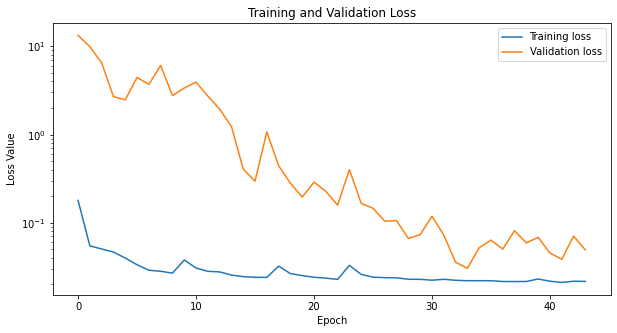

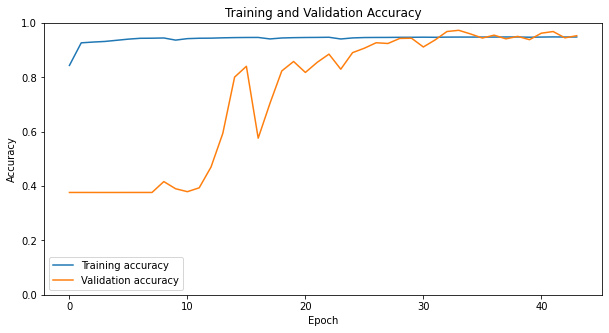

In [ ]:
plot_loss(Unet_history)
plot_accuracy(Unet_history)

In [ ]:
def show_predictions(model, dataset, batch_size, grayscale=False):
  """"
  Show prediction and masking operation result from a given model

  Arguments:
  -model: atrained model
  -dataset: test dataset
  -batch_size
  -grayscale: show grayscale prediction
  """

  #Check that input dataset is our test dataset (we don't want to predict on training images)
  if len(dataset.take(1))!=1:
    print("Wrong dataset!")
    return

  for image in dataset.unbatch().shuffle(buffer_size=batch_size).take(1):
    numpy_img = np.repeat(np.expand_dims(image.numpy(), axis=0), batch_size, axis=0)
    pred = model.predict(numpy_img)
  fig, ax = plt.subplots(1,2, figsize=(10, 5))
  pred = tf.where(pred < 0.5, 0.0, 1.0) # binarization provides the actual mask
  if grayscale:
    ax[0].imshow(pred[0][:, :, 0], cmap='gray')
  else:
    ax[0].imshow(pred[0])    
  ax[1].imshow(image)

1/1 [==============================] - 1s 907ms/step


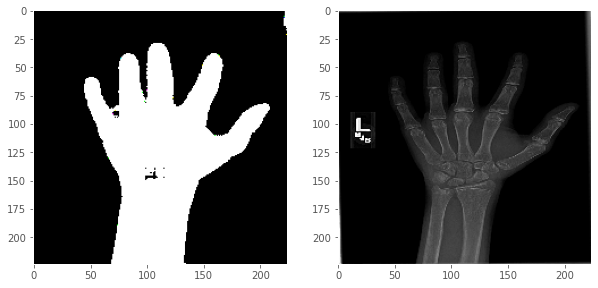

In [ ]:
show_predictions(Unet, test_dataset, BATCH_SIZE)

####Apply masking to original images

We feed the U-Net with all the datasets to perform masking, saving the results for the next tasks.

In [ ]:
Unet = tf.keras.models.load_model(PATH + 'Unet100epochs_trainable=True_contrast.h5', compile=False)

Load data

In [ ]:
with zipfile.ZipFile(TRAIN_PATH + 'train_contrast.zip', 'r') as f:
  f.extractall('.')
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Validation Set/val_contrast' 'boneage-validation-dataset'
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Test Set/test_contrast' 'boneage-test-dataset'

train_df['image'] = train_df['image'].apply(lambda p: 'train_contrast/'+ p.split('/')[-1])
validation_df['image'] = validation_df['image'].apply(lambda p: 'boneage-validation-dataset/'+ p.split('/')[-1])
test_df['image'] = test_df['image'].apply(lambda p: 'boneage-test-dataset/'+ p.split('/')[-1])

In [ ]:
def apply_masking(df, batch_size, path):
  original_names = df['image']
  load_img = lambda file_name : (file_name.split('/')[-1], normalize_values(load_hand_image(file_name, IMG_SIZE)))
  original_imgs = original_names.map(load_img) # this may take a while for the resizing but it has to be made just once
  for elem in original_imgs:
    name, img = elem
    pred = Unet.predict(np.repeat(np.expand_dims(img, axis=0), batch_size, axis=0))
    tf.keras.preprocessing.image.save_img(path + name, pred[0])

apply_masking(train_df, BATCH_SIZE, "train_masks/")
apply_masking(validation_df, BATCH_SIZE, "val_masks/")
apply_masking(test_df, BATCH_SIZE, "test_masks/")

Apply masks

In [ ]:
apply_masks(train_df, TRAIN_PATH_MASKS, IMG_SIZE, 'boneage-training-dataset-masked/')
apply_masks(validation_df, VAL_PATH_MASKS, IMG_SIZE, 'boneage-validation-dataset-masked/')
apply_masks(test_df, TEST_PATH_MASKS, IMG_SIZE, 'boneage-test-dataset-masked/')

Change the path of the images with the one corresponding to the preprocessing

In [ ]:
train_df['image'] = train_df['image'].apply(lambda p: 'boneage-training-dataset-masked/'+ p.split('/')[-1])
validation_df['image'] = validation_df['image'].apply(lambda p: 'boneage-validation-dataset-masked/'+ p.split('/')[-1])
test_df['image'] = test_df['image'].apply(lambda p: 'boneage-test-dataset-masked/'+ p.split('/')[-1])

Visualize preprocessing pipeline

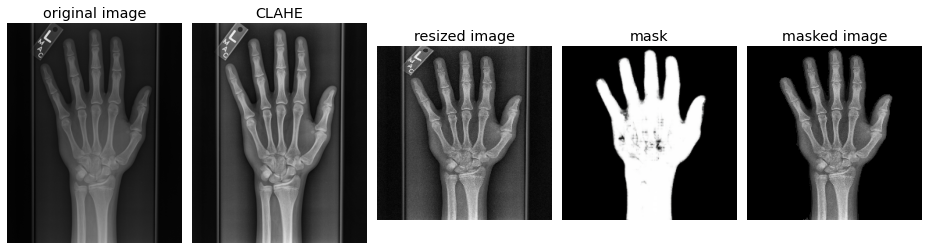

In [ ]:
or_path = TEST_PATH + 'Test Set Images/'
clahe_path = TEST_PATH + 'test_contrast/'
mask_path = TEST_PATH + 'test_masks2/'
masked_path = 'boneage-test-dataset-masked/'
visualize_preprocessing(test_df, or_path, clahe_path, mask_path, masked_path, IMG_SIZE, ind=9)

## Data augmentation, Batching, Normalization

In [ ]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, BATCH_SIZE, shuffle=True, seed=1)
val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, BATCH_SIZE, shuffle=True, seed=1)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

## Models for prediction

In [ ]:
MODELS = ['incV3', 'incV4', 'vgg16', 'incRes', 'incV3 nogender', 'incV3 Male', 'incV3 Female']
LOSS = 'mean_absolute_error'
OPTIM = 'adam'

We use the mean absolute error as metric, as suggested in the papers

In [ ]:
from keras.metrics import mean_absolute_error
def mae_in_months(x, y):
    """
    Return mean absolute error in months

    Arguments:
    x -- predicted value
    y -- ground-truth
    """
    mean_bone_age = train_df['boneage'].mean()
    std_bone_age = train_df['boneage'].std()
    return mean_absolute_error((std_bone_age*x + mean_bone_age), (std_bone_age*y + mean_bone_age)) 

Create the callbacks for the fit function

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto',
                                min_delta=0.0001, cooldown=5, min_lr=0.0000001)

class CustomCallback(Callback):
    def __init__(self):
        self.timeref = time.time() # time reference to compute the training time
        self.loss = []
        self.val_loss = []
    def on_epoch_end(self, epoch,logs = {}):
        logs['train_time'] = time.time() - self.timeref # training time
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
    def on_train_end(self, logs = {}):
        # plot the learning curve when training is finished
        plt.figure(figsize=(10, 5))
        plt.yscale('log')
        plt.plot(range(len(self.loss)), self.loss, label='Training loss')
        plt.plot(range(len(self.loss)), self.val_loss, label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Value')
        plt.legend()
        plt.show()

### Inception-v3

In [ ]:
# callback function to save the best version of the model
# i.e. the one with lower validation loss
weight_path = PATH + 'models_checkpoints/{}_weights.best.hdf5'.format(MODELS[0])
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
# callback function to save the training data in a .log file
csv_logger = CSVLogger(PATH + 'logs/training_{}.log'.format(MODELS[0]), append=True)

callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV3_model = create_model(MODELS[0], IMG_SHAPE, LOSS, OPTIM, mae_in_months)
fit_boneage(incV3_model, train_gen, train_steps, val_gen, val_steps, EPOCHS, callbacks)

### Inception-v4

In [ ]:
weight_path = PATH + 'models_checkpoints/{}_weights.best.hdf5'.format(MODELS[1])
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger(PATH + 'logs/training_{}.log'.format(MODELS[1]), append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV4_model = create_model(MODELS[1], IMG_SHAPE, LOSS, OPTIM, mae_in_months)
fit_boneage(incV4_model, train_gen, train_steps, val_gen, val_steps, EPOCHS, callbacks)

### VGG16

In [ ]:
weight_path = PATH + 'models_checkpoints/{}_weights.best.hdf5'.format(MODELS[2])
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger(PATH + 'logs/training_{}.log'.format(MODELS[2]), append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

optim = tf.keras.optimizers.Adam(learning_rate=0.00001) # VGGNet requires a much lower learning rate
vgg16_model = create_model(MODELS[2], IMG_SHAPE, LOSS, optim, mae_in_months)
fit_boneage(vgg16_model, train_gen, train_steps, val_gen, val_steps, EPOCHS, callbacks)

### Inception-ResNet-v2

In [ ]:
weight_path = PATH + 'models_checkpoints/{}_weights.best.hdf5'.format(MODELS[3])
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger(PATH + 'logs/training_{}.log'.format(MODELS[3]), append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incRes_model = create_model(MODELS[3], IMG_SHAPE, LOSS, OPTIM, mae_in_months)
fit_boneage(incRes_model, train_gen, train_steps, val_gen, val_steps, EPOCHS, callbacks)

## Gender assesment


### No gender

In [ ]:
weight_path = PATH + 'models_checkpoints/{}-gender=None_weights.best.hdf5'.format(MODELS[0])
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger(PATH + 'logs/training_{}-gender=None.log'.format(MODELS[0]), append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV3_nogender = create_model(MODELS[0], IMG_SHAPE, LOSS, optim, mae_in_months, with_gender=False)
fit_boneage(incV3_nogender, train_gen, train_steps, val_gen, val_steps, EPOCHS, callbacks)

### Gender specific

Males only

In [ ]:
# filtering new dataframes
train_df_M = train_df[train_df['gender(M/F)'] == 1]
validation_df_M = validation_df[validation_df['gender(M/F)'] == 1]
test_df_M = test_df[test_df['gender(M/F)'] == 1]

# number of steps between epochs
train_steps_M = int(np.ceil(train_df_M.shape[0] / BATCH_SIZE))
val_steps_M = int(np.ceil(validation_df_M.shape[0] / BATCH_SIZE))

print(train_df_M.shape[0], validation_df_M.shape[0], test_df_M.shape[0])

6833 773 100


In [ ]:
# new generators
datagen_train_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_M = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_M = gen_2inputs(datagen_train_M, train_df_M, IMG_SIZE, BATCH_SIZE, shuffle=True, seed=1)
val_gen_M = gen_2inputs(datagen_val_M, validation_df_M, IMG_SIZE, BATCH_SIZE, shuffle=True, seed=1)
test_gen_M = gen_2inputs(datagen_test_M, test_df_M, IMG_SIZE, test_df_M.shape[0])

In [ ]:
weight_path = PATH + 'models_checkpoints/{}-gender=Male_weights.best.hdf5'.format(MODELS[0])
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger(PATH + 'logs/training_{}-gender=Male.log'.format(MODELS[0]), append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV3_M = create_model(MODELS[0], IMG_SHAPE, LOSS, optim, mae_in_months, with_gender=False)
fit_boneage(incV3_M, train_gen, train_steps, val_gen, val_steps, EPOCHS, callbacks)

Females only

In [ ]:
# filtering new dataframes
train_df_F = train_df[train_df['gender(M/F)'] == 0]
validation_df_F = validation_df[validation_df['gender(M/F)'] == 0]
test_df_F = test_df[test_df['gender(M/F)'] == 0]

# number of steps between epochs
train_steps_F = int(np.ceil(train_df_F.shape[0] / BATCH_SIZE))
val_steps_F = int(np.ceil(validation_df_F.shape[0] / BATCH_SIZE))

print(train_df_F.shape[0], validation_df_F.shape[0], test_df_F.shape[0])

5778 652 100


In [ ]:
# new generators
datagen_train_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_F = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_F = gen_2inputs(datagen_train_F, train_df_F, IMG_SIZE, BATCH_SIZE, shuffle=True, seed=1)
val_gen_F = gen_2inputs(datagen_val_F, validation_df_F, IMG_SIZE, BATCH_SIZE, shuffle=True, seed=1)
test_gen_F = gen_2inputs(datagen_test_F, test_df_F, IMG_SIZE, test_df_F.shape[0])

In [ ]:
weight_path = PATH + 'models_checkpoints/{}-gender=Female_weights.best.hdf5'.format(MODELS[0])
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger(PATH + 'logs/training_{}-gender=Female.log'.format(MODELS[0]), append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV3_F = create_model(MODELS[0], IMG_SHAPE, LOSS, optim, mae_in_months, with_gender=False)
fit_boneage(incV3_F, train_gen, train_steps, val_gen, val_steps, EPOCHS, callbacks)

## Model evaluation

Choose one of the following models:
['incV3', 'incV4', 'vgg16', 'incRes', 'incV3 nogender', 'incV3 Male', 'incV3 Female']
 incV3
Found 200 validated image filenames.
Found 200 validated image filenames.
7/7 [==============================] - 4s 190ms/step
EVALUATION FINISHED

Loss: 0.18177548050880432
Mean Absolute Error (months): 7.485881805419922
Max Error (months): 26.17877954175802
Median Error (months): 6.839164936377834


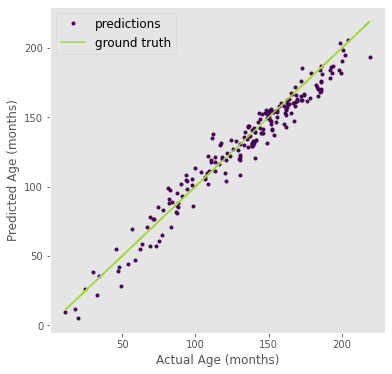

In [ ]:
model_name = input('Choose one of the following models:\n{}\n '.format(str(MODELS)))
gender = False

if model_name == 'incV3 nogender':
  weight_path = PATH + 'models_checkpoints/{}-gender=None_weights.best.hdf5'.format(MODELS[0])
  logs_path = PATH + 'logs/training_{}-gender=None.log'.format(MODELS[0])
elif model_name == 'incV3 Male':
  weight_path = PATH + 'models_checkpoints/{}-gender=Male_weights.best.hdf5'.format(MODELS[0])
  logs_path = PATH + 'logs/training_{}-gender=Male.log'.format(MODELS[0])
elif model_name == 'incV3 Female':
  weight_path = PATH + 'models_checkpoints/{}-gender=Female_weights.best.hdf5'.format(MODELS[0])
  logs_path = PATH + 'logs/training_{}-gender=Female.log'.format(MODELS[0])
else:
  weight_path = PATH + 'models_checkpoints/{}_weights.best.hdf5'.format(model_name)
  logs_path = PATH + 'logs/training_{}.log'.format(model_name)
  gender = True

_, _, _, _, _, predictions, gtruth = evaluate_and_predict(model_name, test_gen, weight_path, logs_path, STD_BONE_AGE,
                                                          MEAN_BONE_AGE, gender, plot=True, metric=mae_in_months)

Visualize predictions

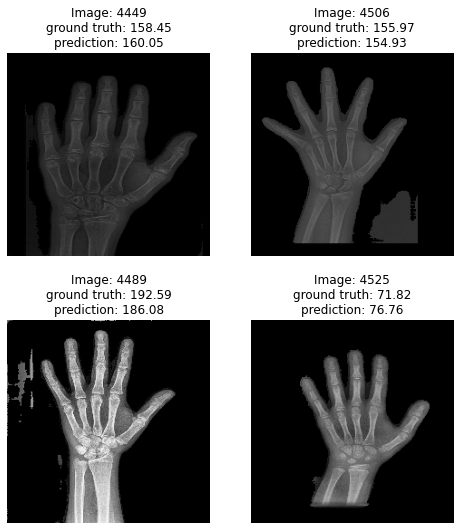

In [ ]:
visualize_preds(test_df, predictions, gtruth)

## Model comparison

In [ ]:
# changing matplotlib.pyplot style
plt.style.use('ggplot')

In [ ]:
incV3, incV3_logs, incV3_params, incV3_test, incV3_r2, _, _ = evaluate_and_predict('incV3', test_gen, PATH + 'models_checkpoints/incV3_weights.best.hdf5', 
                                                              PATH + 'logs/training_incV3.log', STD_BONE_AGE, MEAN_BONE_AGE, metric=mae_in_months)
incV4, incV4_logs, incV4_params, incV4_test, incV4_r2, _, _ = evaluate_and_predict('incV4', test_gen, PATH + 'models_checkpoints/incV4_weights.best.hdf5',
                                                              PATH + 'logs/training_incV4.log', STD_BONE_AGE, MEAN_BONE_AGE, metric=mae_in_months)
vgg16, vgg16_logs, vgg16_params, vgg16_test, vgg16_r2, _, _ = evaluate_and_predict('vgg16', test_gen, PATH + 'models_checkpoints/vgg16_weights.best.hdf5',
                                                              PATH + 'logs/training_vgg16.log', STD_BONE_AGE, MEAN_BONE_AGE, metric=mae_in_months)
incres, incres_logs, incres_params, incres_test, incres_r2, _, _ = evaluate_and_predict('incRes', test_gen, PATH + 'models_checkpoints/incRes_weights.best.hdf5',
                                                                   PATH + 'logs/training_incRes.log', STD_BONE_AGE, MEAN_BONE_AGE, metric=mae_in_months)
incV3nog, incV3nog_logs, incV3nog_params, incV3nog_test, incV3nog_r2, _, _ = evaluate_and_predict('incV3', test_gen, 
                                                                              PATH + 'models_checkpoints/incV3-gender=None_weights.best.hdf5', 
                                                                              PATH + 'logs/training_incV3-gender=None.log', STD_BONE_AGE, 
                                                                              MEAN_BONE_AGE, metric=mae_in_months, gender=False)
incV3M, incV3M_logs, incV3M_params, incV3M_test, incV3M_r2, _, _ = evaluate_and_predict('incV3', test_gen_M, PATH + 'models_checkpoints/incV3-gender=Male_weights.best.hdf5', 
                                                                    PATH + 'logs/training_incV3-gender=Male.log', STD_BONE_AGE, MEAN_BONE_AGE,
                                                                     metric=mae_in_months, gender=False)
incV3F, incV3F_logs, incV3F_params, incV3F_test, incV3F_r2, _, _ = evaluate_and_predict('incV3', test_gen_F, PATH + 'models_checkpoints/incV3-gender=Female_weights.best.hdf5', 
                                                                    PATH + 'logs/training_incV3-gender=Female.log', STD_BONE_AGE, MEAN_BONE_AGE,
                                                                     metric=mae_in_months, gender=False)

Found 200 validated image filenames.
Found 200 validated image filenames.
7/7 [==============================] - 2s 82ms/step


Found 100 validated image filenames.
Found 100 validated image filenames.
4/4 [==============================] - 2s 332ms/step


Found 100 validated image filenames.
Found 100 validated image filenames.
4/4 [==============================] - 3s 96ms/step


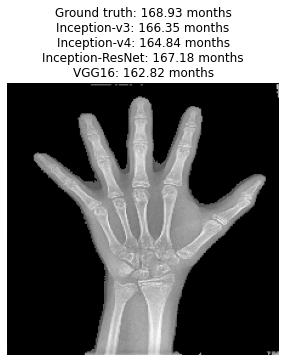

In [ ]:
t = next(test_gen)
image = t[0][0][0]
gender = t[0][1][0]
truth = t[1][0]

im_gender = [np.expand_dims(image, axis=0), tf.constant([gender], dtype=tf.uint8)]

p1 = float(STD_BONE_AGE * incV3.predict(im_gender) + MEAN_BONE_AGE)
p2 = float(STD_BONE_AGE * incV4.predict(im_gender) + MEAN_BONE_AGE)
p3 = float(STD_BONE_AGE * incres.predict(im_gender) + MEAN_BONE_AGE)
p4 = float(STD_BONE_AGE * vgg16.predict(im_gender) + MEAN_BONE_AGE)
g = float(STD_BONE_AGE * truth + MEAN_BONE_AGE)
p1 = round(p1, 2)
p2 = round(p2, 2)
p3 = round(p3, 2)
p4 = round(p4, 2)
g = round(g, 2)

plt.figure(figsize=(6,5))
plt.axis('off')
plt.title('Ground truth: {} months\nInception-v3: {} months\nInception-v4: {} months\nInception-ResNet: {} months\nVGG16: {} months'.format(g, p1, p2, p3, p4), size=12)
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

We should take the best results of the model, which corresponds to the ones where the *val_loss* is the lowest.

In [ ]:
ind = [np.argmin(incV3_logs['val_loss']), np.argmin(incV4_logs['val_loss']), np.argmin(vgg16_logs['val_loss']),
       np.argmin(incres_logs['val_loss']), np.argmin(incV3nog_logs['val_loss']), np.argmin(incV3M_logs['val_loss']),
       np.argmin(incV3F_logs['val_loss'])]

Plot #parameters

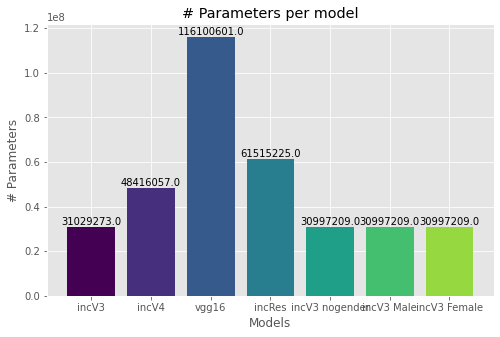

In [ ]:
num_params = [incV3_params, incV4_params, vgg16_params, incres_params, incV3nog_params, incV3M_params, incV3F_params]

plot_bars(num_params, COLORS, '# Parameters per model', 'Models', '# Parameters')

Plot training time

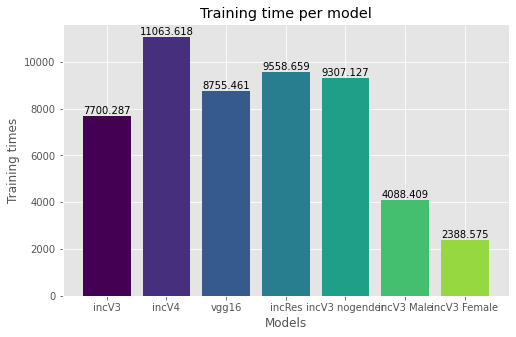

In [ ]:
tr_times = [list(incV3_logs['train_time'])[ind[0]], list(incV4_logs['train_time'])[ind[1]], list(vgg16_logs['train_time'])[ind[2]], 
            list(incres_logs['train_time'])[ind[3]], list(incV3nog_logs['train_time'])[ind[4]], list(incV3M_logs['train_time'])[ind[5]],
            list(incV3F_logs['train_time'])[ind[6]]]

plot_bars(tr_times, COLORS, 'Training time per model', 'Models', 'Training times')

Plot accuracy/loss

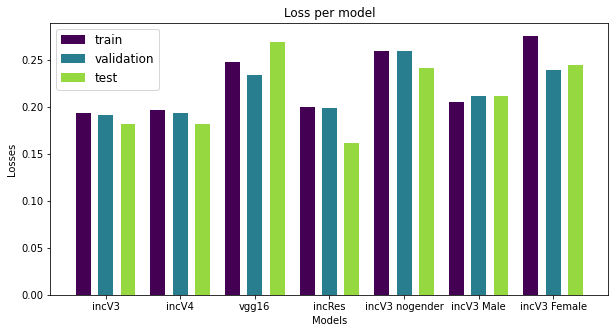

In [ ]:
losses = [list(incV3_logs['loss'])[ind[0]], list(incV4_logs['loss'])[ind[1]], list(vgg16_logs['loss'])[ind[2]],
          list(incres_logs['loss'])[ind[3]], list(incV3nog_logs['loss'])[ind[4]], list(incV3M_logs['loss'])[ind[5]], 
          list(incV3F_logs['loss'])[ind[6]]]
val_losses = [list(incV3_logs['val_loss'])[ind[0]], list(incV4_logs['val_loss'])[ind[1]], list(vgg16_logs['val_loss'])[ind[2]], 
          list(incres_logs['val_loss'])[ind[3]], list(incV3nog_logs['val_loss'])[ind[4]], list(incV3M_logs['val_loss'])[ind[5]], 
          list(incV3F_logs['val_loss'])[ind[6]]]
test_losses = [incV3_test[0], incV4_test[0], vgg16_test[0], incres_test[0], incV3nog_test[0], incV3M_test[0], incV3F_test[0]]

plot_bars(losses, COLORS, 'Loss per model', 'Models', 'Losses', val_losses, test_losses)

Plot MAE

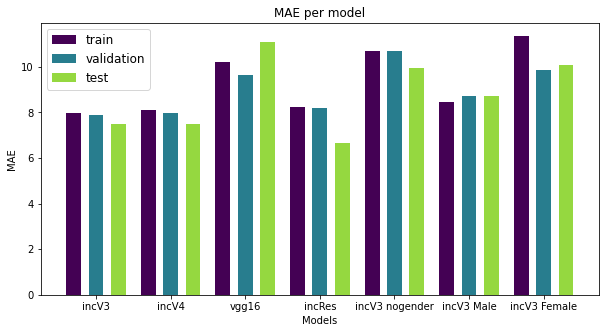

In [ ]:
maes = [list(incV3_logs['mae_in_months'])[ind[0]], list(incV4_logs['mae_in_months'])[ind[1]], list(vgg16_logs['mae_in_months'])[ind[2]], 
        list(incres_logs['mae_in_months'])[ind[3]], list(incV3nog_logs['mae_in_months'])[ind[4]], list(incV3M_logs['mae_in_months'])[ind[5]], 
        list(incV3F_logs['mae_in_months'])[ind[6]]]
val_maes = [list(incV3_logs['val_mae_in_months'])[ind[0]], list(incV4_logs['val_mae_in_months'])[ind[1]], list(vgg16_logs['val_mae_in_months'])[ind[2]], 
            list(incres_logs['val_mae_in_months'])[ind[3]], list(incV3nog_logs['val_mae_in_months'])[ind[4]], list(incV3M_logs['val_mae_in_months'])[ind[5]], 
            list(incV3F_logs['val_mae_in_months'])[ind[6]]]
test_maes = [incV3_test[1], incV4_test[1], vgg16_test[1], incres_test[1], incV3nog_test[1], incV3M_test[1], incV3F_test[1]]

plot_bars(maes, COLORS, 'MAE per model', 'Models', 'MAE', val_maes, test_maes)

Plot R2 score

In [ ]:
r2s = [incV3_r2, incV4_r2, vgg16_r2, incres_r2, incV3nog_r2, incV3M_r2, incV3F_r2]

plot_bars(r2s, COLORS, 'R2 score per model', 'Models', 'R2 score')

In [ ]:
def plot_bars(values, color, title, xlabel, ylabel, values_2=None, values_3=None, annotate=True):
  x_pos = np.arange(len(models))
  fig, ax = plt.subplots(figsize=(8, 5))
  plots = plt.bar(x_pos, values, color=color, alpha=0.8, edgecolor='black', width=0.5)
  if annotate:
    for i in range(len(models)):
      plt.annotate(int(values[i]*1000)/1000, (x_pos[i], values[i]), ha='center', va='center',
                  size=12, xytext=(0,7), textcoords='offset points')
  plt.xticks(x_pos, models)
  # plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.ylim((0, 1.1))
  plt.savefig('r2.png')
  plt.show()

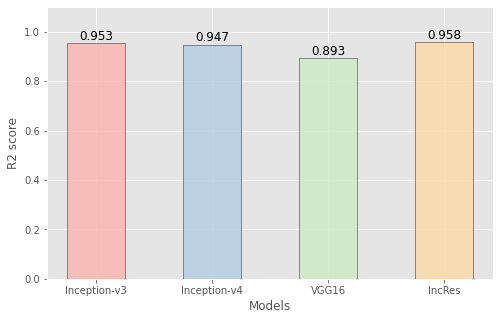

<Figure size 1080x720 with 0 Axes>

In [ ]:
cmap = mpl.cm.get_cmap('Pastel1')
colors = [cmap(0.0), cmap(0.16), cmap(0.33), cmap(0.49), cmap(0.66), cmap(0.83)]
r2s = [incV3_r2, incV4_r2, vgg16_r2, incres_r2]

models = ['Inception-v3', 'Inception-v4', 'VGG16', 'IncRes']

plot_bars(r2s, [colors[0], colors[1], colors[2], colors[3]], 'R2 score per model', 'Models', 'R2 score')

Training loss flow

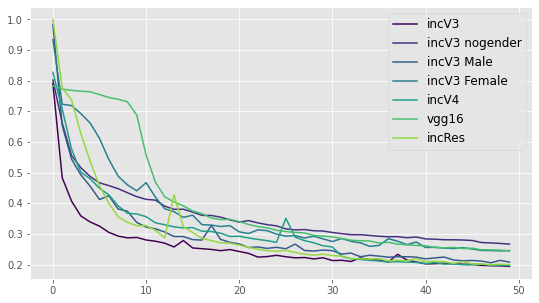

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

plt.plot(np.array(incV3_logs['loss']), label='incV3', c=COLORS[0])
plt.plot(np.array(incV3nog_logs['loss'][:50]), label='incV3 nogender', c=COLORS[1])
plt.plot(np.array(incV3M_logs['loss']), label='incV3 Male', c=COLORS[2])
plt.plot(np.array(incV3F_logs['loss']), label='incV3 Female', c=COLORS[3])
plt.plot(np.array(incV4_logs['loss']), label='incV4', c=COLORS[4])
plt.plot(np.array(vgg16_logs['loss']), label='vgg16', c=COLORS[5])
incres_loss = incres_logs['loss'].copy()
incres_loss[0] = 1
plt.plot(np.array(incres_loss), label='incRes', c=COLORS[6])
plt.legend()
plt.show()

Bubbles

In [ ]:
def plot_bubbles(models, x, y, z, xlabel, ylabel):
  fig, _ = plt.subplots(figsize=(8, 5))
  plt.scatter(x = x, y = y, s=z/10000, c=COLORS, 
              alpha=0.6, edgecolors="white", linewidth=2)
  
  plt.xlim(1500, 12500)
  plt.ylim(0.1, 0.33)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  for i, txt in enumerate(models):
    plt.annotate(txt, (x[i], y[i]), ha='center', va='center',
                 size=10, xytext=(0,0), textcoords='offset points')
  plt.show()

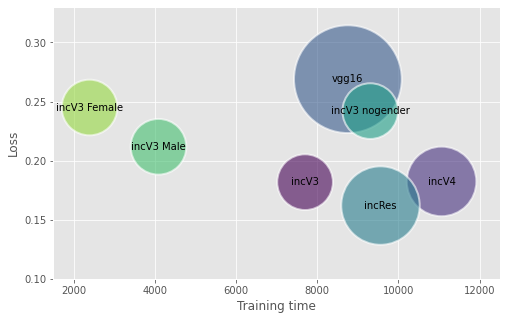

In [ ]:
plot_bubbles(MODELS, np.array(tr_times), np.array(test_losses), np.array(num_params), 'Training time', 'Loss')

##Ensemble 

###Load previously trained models and checkpoints

In [ ]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_res.py" inc_res.py
from inc_res import *

In [ ]:
def create_model(model_name, img_shape, loss, optim, metric, with_gender=True):
    """
    Implementation of an architecture for bone age prediction with different backbone models
    
    Arguments:
    model_name -- name of the chosen backbone model
    img_shape -- shape of the images of the dataset
    loss -- loss with which to compile the model
    optim -- optimizer with which to compile the model
    metric -- metric with which to compile the model
    with_gender -- if False, gender data is not used in the model
    
    Returns:
    Model() instance in Keras
    """

    X_input = Input(shape=img_shape)
    gen_input = Input(shape=(1,))

    # choose backbone
    if model_name == 'incV3':
        # Inception block (image data)    
        inc_model = InceptionV3(input_tensor=X_input, input_shape=img_shape, include_top=False, weights=None)
        inc_model.trainable=True
        X = inc_model.get_layer('mixed10').output # 14 x 14 x 2048
        X = AveragePooling2D((2, 2))(X) # 7 x 7 x 2048

    if model_name == 'incV4':
        # Inception block (image data)
        X = Inceptionv4(X_input, include_top=False) # 14 x 14 x 1536
        X = AveragePooling2D((2, 2))(X) # 7 x 7 x 1536

    if model_name == 'simple_conv':
        # Convolutional block (image data)
        X = Conv2D(32, (3,3), activation='relu')(X_input)
        X = MaxPooling2D((2, 2))(X)
        X = Conv2D(64, (3,3), activation='relu')(X)
        X = MaxPooling2D((2, 2))(X)
        X = Conv2D(128, (3,3), activation='relu')(X)
        X = MaxPooling2D((2, 2))(X)

    if model_name == 'vgg16':
        # VGG16 block (image data)
        vgg16_model = VGG16(input_tensor=X_input, include_top=False, weights=None)
        vgg16_model.trainable = True
        X = vgg16_model.get_layer('block5_conv3').output

    if model_name == 'incRes':
        # Inception block (image data)
        X = InceptionResNetV2(X_input, include_top=False)
        # incres = tf.keras.applications.InceptionResNetV2(input_tensor=X_input, include_top=False, weights=None)
        # X = incres.layers[-1].get_output_at(0)
        X = AveragePooling2D((2, 2))(X)

    # common structure after backbone
    X = Flatten()(X)

    if with_gender:
        # Dense block (gender data)
        gen = Dense(32, activation='relu')(gen_input)

        # Concatenation of image and gender data
        X = tf.concat(values=[X, gen], axis=1)

    # First Dense block
    X = Dense(1000, activation='relu')(X)

    # Second Dense block
    X = Dense(1000, activation='relu')(X)

    # Fully connected layer
    X = Dense(1)(X)

    model = tf.keras.Model(inputs=[X_input, gen_input], outputs=X, name=model_name)
    model.compile(loss=loss, optimizer=optim, metrics=[metric])

    return model

In [ ]:
models=[
    ('incV3',"incV3_weights.best.hdf5"),
    ("incV4", "incV4_weights.best.hdf5"),
    ('incRes', "incRes_weights_08-02.best.hdf5")
    ]

for i,model in enumerate(models):
    model_name, weight_path = model
    model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=True)
    model.load_weights(PATH + 'models_checkpoints/' + weight_path)
    model.trainable = False
    models[i]=model

###Ensamble models

####Average Ensamble

In [ ]:
def average_ensamble(models, img_shape):
    """
    Implementation of an architecture for bone age prediction with different backbone models
     
    Arguments:
    model_name -- name of the chosen backbone model
    img_shape -- shape of the images of the dataset
    loss -- loss with which to compile the model
    optim -- optimizer with which to compile the model
    metric -- metric with which to compile the model 
    with_gender -- if False, gender data is not used in the model
    
    Returns:
    Model() instance in Keras
    """

    X_input = Input(shape=img_shape)
    gen_input = Input(shape=(1,))

    num_models = len(models)

    models_results = [model([X_input, gen_input], training=False) for model in models]
    models_results = tf.concat(values=[m for m in models_results], axis=1)

    out = tf.reduce_mean(models_results, 1, keepdims=True)


    model = tf.keras.Model(inputs=[X_input, gen_input], outputs=out, name=model_name)
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[mae_in_months])

    return model

####Weighted EnsambleNet

In [ ]:
def create_weight_ensamble(models, img_shape):
    """
    Implementation of an ensemble network bone age prediction with different backbone models:
    
    Arguments:
    models -- pretrained CNNs predictors
    img_shape -- prefered image shape 
    
    Returns:
    Model() instance in Keras
    """

    X_input = Input(shape=img_shape)
    gen_input = Input(shape=(1,))

    num_models = len(models)

    models_results = [model([X_input, gen_input], training=False) for model in models]
    models_results = tf.concat(values=[m for m in models_results], axis=1)

    # Weighting CNN
    X = Conv2D(2, (3,3), activation='relu')(X_input)
    X = MaxPooling2D((2, 2))(X)
    X = Conv2D(4, (3,3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Conv2D(8, (3,3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Conv2D(16, (3,3), activation='relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Flatten()(X)

    # Gender input
    gen = Dense(32, activation='relu')(gen_input)

    # Models result dense layer
    Y = Dense(300, activation='relu')(models_results)

    # Concatenation of image and gender data
    X = tf.concat(values=[X, Y, gen], axis=1)

    # Dense net
    X = Dense(100, activation='relu')(X)
    Weights = Dense(num_models, activation='softmax')(X)

    out = tf.reduce_sum(Weights*models_results, 1, keepdims=True)   

    optim = tf.keras.optimizers.Adam(10**-4)
    model = tf.keras.Model(inputs=[X_input, gen_input], outputs=out, name=model_name)
    model.compile(loss='mean_absolute_error', optimizer=optim, metrics=[mae_in_months])

    return model

####Train

In [ ]:
#Train weighted ensamble
ensamblenet = create_weight_ensamble(models, (224,224,1))

# Callbacks
model_name = 'ensamblenet'
weight_path = PATH + 'models_checkpoints/'+ "{}-DEMO_weights.best.hdf5".format(model_name)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=3, min_lr=10**-8)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/HDA_Project/ensamble_DEMO.log', append=True)

callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

model_history = ensamblenet.fit(train_gen, steps_per_epoch=train_steps, validation_data=val_gen, validation_steps=val_steps, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

###Evaluation

####Average Ensamble

In [ ]:
average_ensamble = average_ensamble(models, (224,224,1))

In [ ]:
loss, mae = average_ensamble.evaluate(test_gen, verbose=2, steps=1)

Found 200 validated image filenames.
Found 200 validated image filenames.
1/1 - 24s - loss: 0.1570 - mae_in_months: 6.4662 - 24s/epoch - 24s/step


####Weighted ensamble

In [ ]:
ensamblenet = create_weight_ensamble(models, (224,224,1))

In [ ]:
model_name = 'ensamblenet'
weight_path = PATH + 'models_checkpoints/'+ "{}-DEMO_weights.best.hdf5".format(model_name)
ensamblenet.load_weights(weight_path)

In [ ]:
loss, mae = ensamblenet.evaluate(test_gen, verbose=2, steps=1)

1/1 - 12s - loss: 0.1578 - mae_in_months: 6.5005 - 12s/epoch - 12s/step


In [ ]:
test_data, test_gtruth = next(test_gen)
# predict model on test data
prediction = STD_BONE_AGE * ensamblenet.predict(test_data, batch_size=BATCH_SIZE, verbose=True) + MEAN_BONE_AGE
test_gtruth_months = STD_BONE_AGE * test_gtruth + MEAN_BONE_AGE

7/7 [==============================] - 128s 16s/step


###Preprocessing relevance assessment

We perform evaluation for Inc-V3 model without preprocessing (both contrast and hand segmentation) and just without hand segmentation. The result show a big difference from the model evaluated on the preprocessed dataset which show 7.485 MAE.

In [ ]:
# Load original test dataset
test_df = load_filenames(TEST_PATH + 'Bone age ground truth.xlsx', TEST_PATH + '/Test Set Images')
test_df['boneage_n'] = (test_df['boneage'] - MEAN_BONE_AGE) / STD_BONE_AGE
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

# Load model
model_name = 'incV3'
weight_path = PATH + 'models_checkpoints/{}_weights.best.hdf5'.format(model_name)
gender = True
incv3 = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
incv3.load_weights(weight_path)

# Evaluate
incv3.evaluate(test_gen, verbose=2, steps=1)

Found 200 validated image filenames.
Found 200 validated image filenames.
1/1 - 4s - loss: 0.3627 - mae_in_months: 14.9376 - 4s/epoch - 4s/step


[0.3627217411994934, 14.937614440917969]

In [ ]:
# Load original test dataset
test_df = load_filenames(TEST_PATH + '/Bone age ground truth.xlsx', TEST_PATH + '/test_contrast')
MEAN_BONE_AGE = train_df['boneage'].mean()
STD_BONE_AGE = train_df['boneage'].std()
test_df['boneage_n'] = (test_df['boneage'] - MEAN_BONE_AGE) / STD_BONE_AGE
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

# Load model
model_name = 'incV3'
weight_path = path + 'models_checkpoints/{}_weights.best.hdf5'.format(model_name)
gender = True
incv3 = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
incv3.load_weights(weight_path)

# Evaluate
incv3.evaluate(test_gen, verbose=2, steps=1)

Found 200 validated image filenames.
Found 200 validated image filenames.
1/1 - 3s - loss: 0.2093 - mae_in_months: 8.6180 - 3s/epoch - 3s/step


[0.2092663198709488, 8.618009567260742]